# Topic Modeling

In [8]:
import pandas as pd
import numpy as np
import nltk

In [2]:
amazon = pd.read_csv('amazon_reviews_big.csv')
amazon.shape

(100000, 8)

In [3]:
amazon.head()

,asin,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,B000HDJXNA,1,What I recieved is not what is pictured here O...,"12 26, 2012",A29YXBFTD7QUP3,HHA,Buyer be ware,1.356480e+09
1,B006KKS7XQ,5,Excellent unit and a pretty simple install usi...,"09 20, 2013",A3IMTXFYD7CGDN,"Peter W. George ""soyflakeman""",high quality without high price,1.379635e+09
2,B002NP8XJ0,5,"I'm enjoying this keyboard, I'm getting anothe...","08 31, 2010",AXNOW20FQKHVW,B. Hayashi,Superb keyboard + solution for slow wake up an...,1.283213e+09
3,B000EITTLE,4,"Overall, this is a fantastic camera that I'm e...","02 3, 2008",A10KCAK279LO0W,"mmcwatters ""macdadi80""",One qualm: not great in low light,1.201997e+09
4,B006CRXK4S,5,These work very well with mySamsung PN64D7000 ...,"01 28, 2012",A19XXLMZXR764J,S. Garfinkle,"Work great, fit well",1.327709e+09


In [6]:
import gensim

C:\Users\admin\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [7]:
docs = amazon['reviewText'].fillna('').str.lower().str.replace('[^a-z ]', '')
docs.head()

0    what i recieved is not what is pictured here o...
1    excellent unit and a pretty simple install usi...
2    im enjoying this keyboard im getting another o...
3    overall this is a fantastic camera that im ext...
4    these work very well with mysamsung pnd inch p...
Name: reviewText, dtype: object

In [43]:
docs_clean = []
stopwords = nltk.corpus.stopwords.words('english')
junk_words = ['', 'great', 'would', 'get', 'good', 'use', 'like', 'one',
             'works']

stopwords.extend(junk_words)
for doc in docs:
    row_words = [word for word in doc.split(' ') if word not in stopwords]
    docs_clean.append(row_words)
len(docs_clean)

100000

In [44]:
dictionary = gensim.corpora.Dictionary(docs_clean)

In [21]:
print(dictionary)

Dictionary(176487 unique tokens: ['', 'advertized', 'amazoncom', 'anything', 'attempt']...)


In [37]:
print(dictionary.token2id['anything'])
print(dictionary.id2token[3])

3
anything


In [45]:
docs_bow = [dictionary.doc2bow(doc) for doc in docs_clean]

In [98]:
ldamodel = gensim.models.LdaModel(docs_bow, id2word=dictionary, num_topics=4)
ldamodel

In [111]:
ldamodel.print_topics()

[(0,
  '0.025*"camera" + 0.013*"lens" + 0.011*"battery" + 0.006*"quality" + 0.006*"canon" + 0.006*"batteries" + 0.005*"mm" + 0.005*"light" + 0.005*"pictures" + 0.005*"video"'),
 (1,
  '0.013*"sound" + 0.009*"tv" + 0.008*"quality" + 0.007*"cable" + 0.006*"price" + 0.005*"dont" + 0.005*"speakers" + 0.005*"better" + 0.005*"really" + 0.005*"much"'),
 (2,
  '0.009*"usb" + 0.009*"drive" + 0.006*"computer" + 0.005*"card" + 0.005*"work" + 0.005*"device" + 0.005*"power" + 0.005*"time" + 0.004*"using" + 0.004*"software"'),
 (3,
  '0.018*"case" + 0.008*"well" + 0.007*"ipad" + 0.007*"screen" + 0.007*"keyboard" + 0.005*"fit" + 0.005*"cover" + 0.005*"nice" + 0.005*"little" + 0.005*"product"')]

In [99]:
ldamodel.get_document_topics(docs_bow[600])

[(0, 0.04118218), (2, 0.8570878), (3, 0.10046885)]

In [107]:
pd.DataFrame(ldamodel.get_document_topics(docs_bow[600]),
            columns=['topic', 'prob']).sort_values(
    'prob').tail(1)['topic'].values[0]

2

In [108]:
topics = []
for doc_bow in docs_bow:
    topic = pd.DataFrame(ldamodel.get_document_topics(doc_bow),
            columns=['topic', 'prob']).sort_values(
            'prob').tail(1)['topic'].values[0]
    topics.append(topic)
topics[:5]

[2, 3, 2, 0, 1]

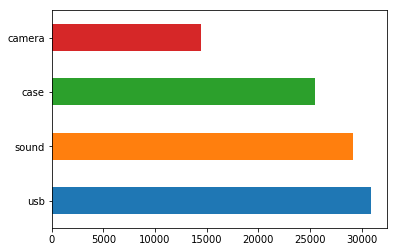

In [113]:
%matplotlib inline
amazon['topic_number'] = topics
amazon['topic'] = amazon['topic_number'].replace({0: 'camera', 1: 'sound',
                                                  2: 'usb', 3: 'case'})
amazon['topic'].value_counts().plot.barh()

In [124]:
ldamodel.get_topic_terms(0)

[(217, 0.025130125),
 (526, 0.013004725),
 (403, 0.0110555375),
 (34, 0.006082288),
 (218, 0.005504521),
 (671, 0.0055003148),
 (266, 0.0053888755),
 (164, 0.00527816),
 (234, 0.005138186),
 (788, 0.004997895)]

In [149]:
df_topic2word = pd.DataFrame()
for topic_number in range(4):
    df = pd.DataFrame(ldamodel.get_topic_terms(topic_number),
                     columns=['wordid', 'prob'])
    df['word'] = df['wordid'].apply(lambda v: dictionary[v])
    df['topic'] = topic_number
    df_topic2word = df_topic2word.append(df, ignore_index=True)
#df_topic2word

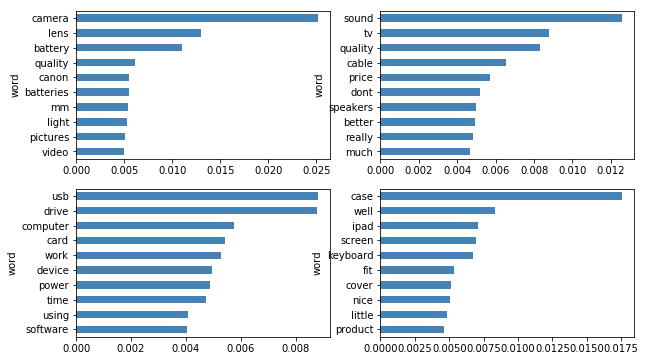

In [147]:
import matplotlib.pyplot as plt
df_topic2word.index = df_topic2word['word']
fig, axs = plt.subplots(2,2)
df_topic2word[df_topic2word['topic']==0]['prob'][::-1].plot.barh(
    color='steelblue', ax=axs[0,0], figsize=(10,6))
df_topic2word[df_topic2word['topic']==1]['prob'][::-1].plot.barh(
    color='steelblue', ax=axs[0,1])
df_topic2word[df_topic2word['topic']==2]['prob'][::-1].plot.barh(
    color='steelblue', ax=axs[1,0])
df_topic2word[df_topic2word['topic']==3]['prob'][::-1].plot.barh(
    color='steelblue', ax=axs[1,1])

# Twitter Scraping

In [155]:
consumer_api = 'Vjaxun6LMPyDH5snUhrIuYO9w'
consumer_api_secret = 'ODe9oDQBmkW7Ra6oxZ4oCPbXmgAgXJLjdJFDfjmt2PfJFd80rh'
access_token = '150321726-RK2lUztz5JP7YbnAgcPEkoKAodbhG37PIp6WhYmQ'
access_secret = 'Jj5mxsTRoqJm5e2vhEsUoc9PZcz9P9HK9zFL57CDoSpWn'

In [160]:
import tweepy
auth = tweepy.OAuthHandler(consumer_api, consumer_api_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

In [163]:
flipkart = api.search('#flipkart', count=1000)
len(flipkart)

100

In [178]:
tweets_flipkart = pd.DataFrame()
for res in flipkart:
    text = res.text
    date = res.created_at
    screen_name = res.user.screen_name
    name = res.user.name
    
    curr_row= {'text': text,
               'date': date,
               'screen_name': screen_name,
               'name': name}
    tweets_flipkart = tweets_flipkart.append(curr_row, ignore_index=True)
tweets_flipkart

,date,name,screen_name,text
0,2019-01-05 10:35:50,Harsh Rawat,Rawat_Harsh61,Received wrong product. No one from #Myntra He...
1,2019-01-05 10:31:25,HS Nepali,hs_nepali,RT @HSnewsLive: ड्राइवर के साथ मिलीभगत करके @F...
2,2019-01-05 10:29:23,Ashok Prasad,ashoksis,RT @HSnewsLive: ड्राइवर के साथ मिलीभगत करके @F...
3,2019-01-05 10:23:31,mariyam ali,mariyam53531058,Participate in Guess What? on Flipkart and win...
4,2019-01-05 09:50:26,Cauvery News,cauverytv,இணையத்தில் வாட்ச் வாங்குவோர் கவனத்திற்கு... செ...
5,2019-01-05 09:43:30,Indalkumar,indalku27375708,RT @nutramantra: #Nutramantra #RichAyurveda\nI...
6,2019-01-05 09:38:45,sabarish,sabarish4,@myntra #feeling #frustrated I really don't kn...
7,2019-01-05 09:38:18,couponframe,CouponFrame,#Runner &amp; #Door #Mat - up to 80% off \nhtt...
8,2019-01-05 09:28:20,Pallav Prince,pallav_prince,Flipkart cheating customer.\nPrice on Flipkart...
9,2019-01-05 09:25:58,Dealogasm,dealogasm,Take your smartphone experience to the next le...
